# 第一周作业 - 基础作业
## 问题描述
数据说明： Capital Bikeshare （美国Washington, D.C.的一个共享单车公司）提供的共享单车数据。数据包含每天的日期、天气等信息，需要预测每天的共享单车骑行量

## 批改标准
1. 对数据做数据探索分析（可参考EDA_BikeSharing.ipynb，不计分） 
2. 适当的特征工程（可参考FE_BikeSharing.ipynb，不计分） 
3. 对全体数据，随机选择其中80%做训练数据，剩下20%为测试数据，评价指标为RMSE。（10分） 
4. 用训练数据训练最小二乘线性回归模型（20分）、岭回归模型、Lasso模型，其中岭回归模型（30分）和Lasso模型（30分）需采用5折交叉验证得到最佳正则超参数。 
5. 比较用上述三种模型得到的各特征的系数，以及各模型在测试集上的性能。并简单说明原因。（10分）

## 1. 导入必要的包

In [61]:
# 数据读取及基本处理
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

# plotting
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

# setting params
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (30, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

sn.set_style('whitegrid')
sn.set_context('talk')

plt.rcParams.update(params)
pd.options.display.max_colwidth = 600

# pandas display data frames as tables
from IPython.display import display, HTML

## 2. 数据探索分析

## 2.1 导入相关的数据

In [3]:
# 读入数据
train = pd.read_csv("day.csv")
train.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
instant       731 non-null int64
dteday        731 non-null object
season        731 non-null int64
yr            731 non-null int64
mnth          731 non-null int64
holiday       731 non-null int64
weekday       731 non-null int64
workingday    731 non-null int64
weathersit    731 non-null int64
temp          731 non-null float64
atemp         731 non-null float64
hum           731 non-null float64
windspeed     731 non-null float64
casual        731 non-null int64
registered    731 non-null int64
cnt           731 non-null int64
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


没有空项

## 数据探索

In [8]:

train.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,366.000000,2.496580,0.500684,6.519836,0.028728,2.997264,0.683995,1.395349,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
std,211.165812,1.110807,0.500342,3.451913,0.167155,2.004787,0.465233,0.544894,0.183051,0.162961,0.142429,0.077498,686.622488,1560.256377,1937.211452
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,183.500000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,366.000000,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,548.500000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,731.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [10]:
#对类别型特征，观察其取值范围及直方图
categorical_features = ['season','mnth','weathersit','weekday']
for col in categorical_features:
    print('\n%s属性的不同取值和出现的次数'%col)
    print(train[col].value_counts())
    train[col] = train[col].astype('object')


season属性的不同取值和出现的次数
3    188
2    184
1    181
4    178
Name: season, dtype: int64

mnth属性的不同取值和出现的次数
12    62
10    62
8     62
7     62
5     62
3     62
1     62
11    60
9     60
6     60
4     60
2     57
Name: mnth, dtype: int64

weathersit属性的不同取值和出现的次数
1    463
2    247
3     21
Name: weathersit, dtype: int64

weekday属性的不同取值和出现的次数
6    105
1    105
0    105
5    104
4    104
3    104
2    104
Name: weekday, dtype: int64


## 每年的分布

/Users/LordLuking/anaconda/envs/tensorflow/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


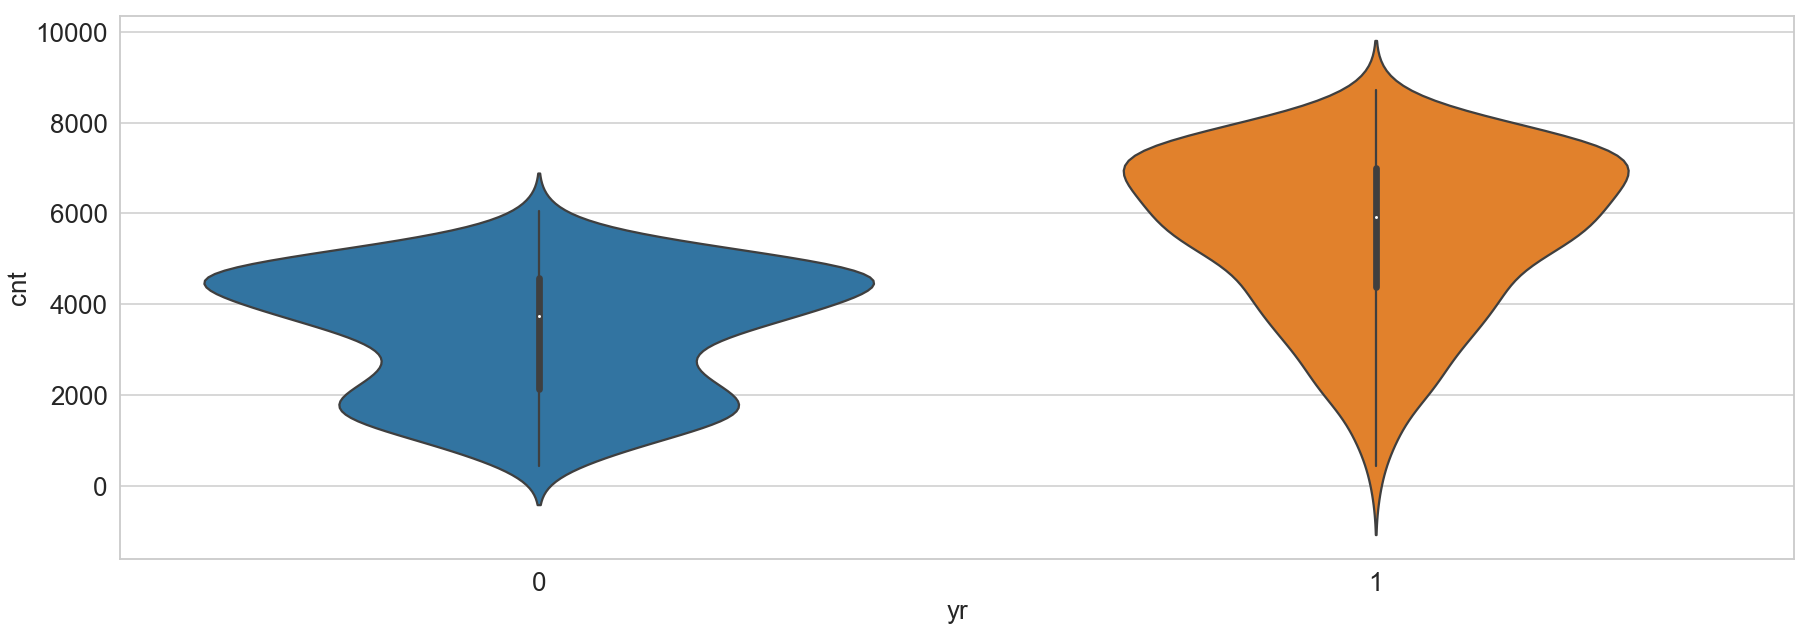

In [16]:
sn.violinplot(data=train[['yr',
                          'cnt']],
              x="yr",y="cnt")

## 一年中每天的骑车量

[Text(0.5, 1.0, 'dayly distribution of counts')]

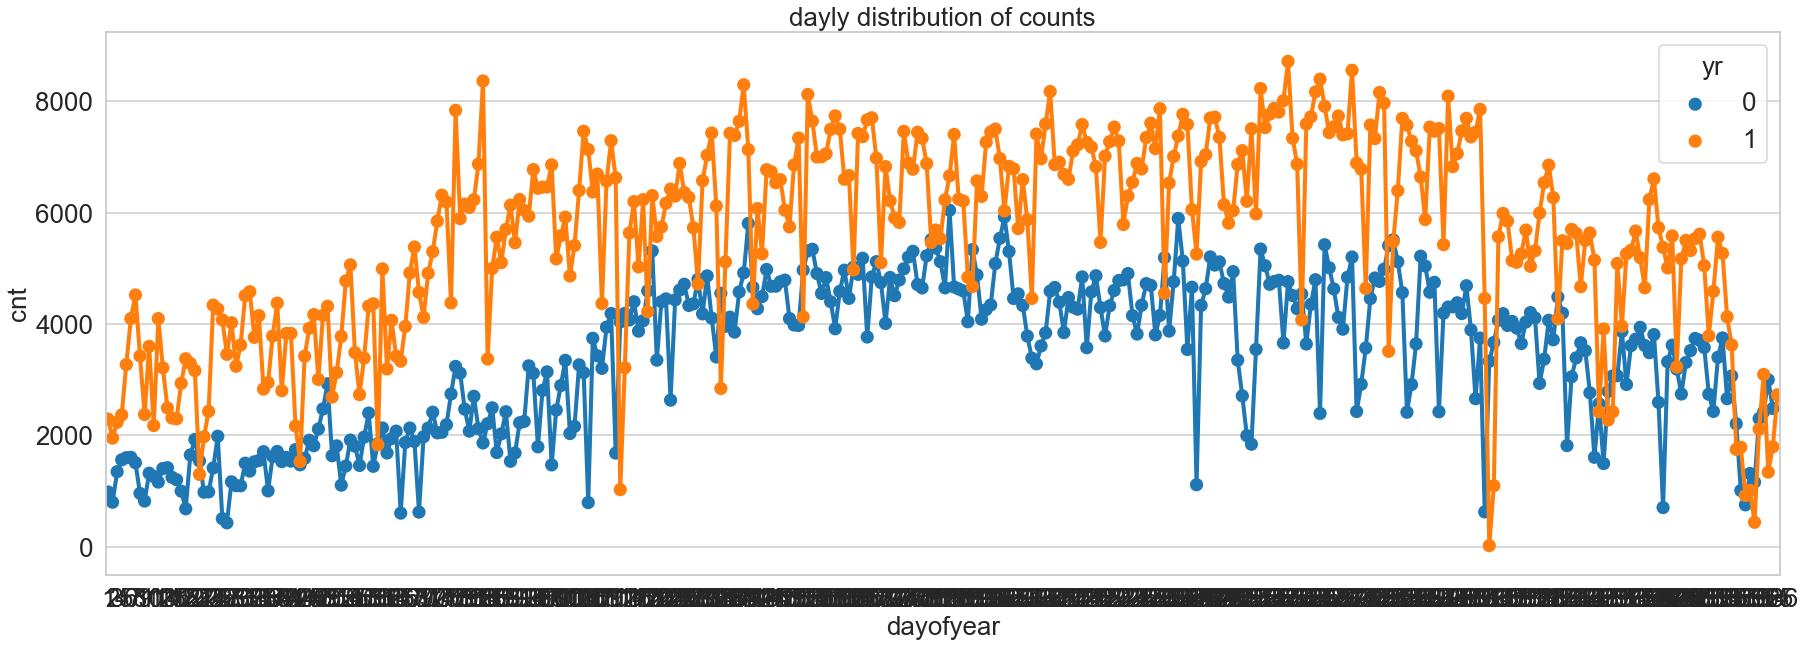

In [17]:
import datetime

train['date'] = pd.to_datetime(train['dteday'])
train['dayofyear'] = train["date"].dt.dayofyear  #减今年的第几天

fig,ax = plt.subplots()
sn.pointplot(data=train[['dayofyear',
                           'cnt',
                           'yr']],
             x='dayofyear',y='cnt',
             hue='yr',ax=ax)
ax.set(title="dayly distribution of counts")

## 季节与骑车数量的关系

[Text(0.5, 1.0, 'Seasonly distribution of counts')]

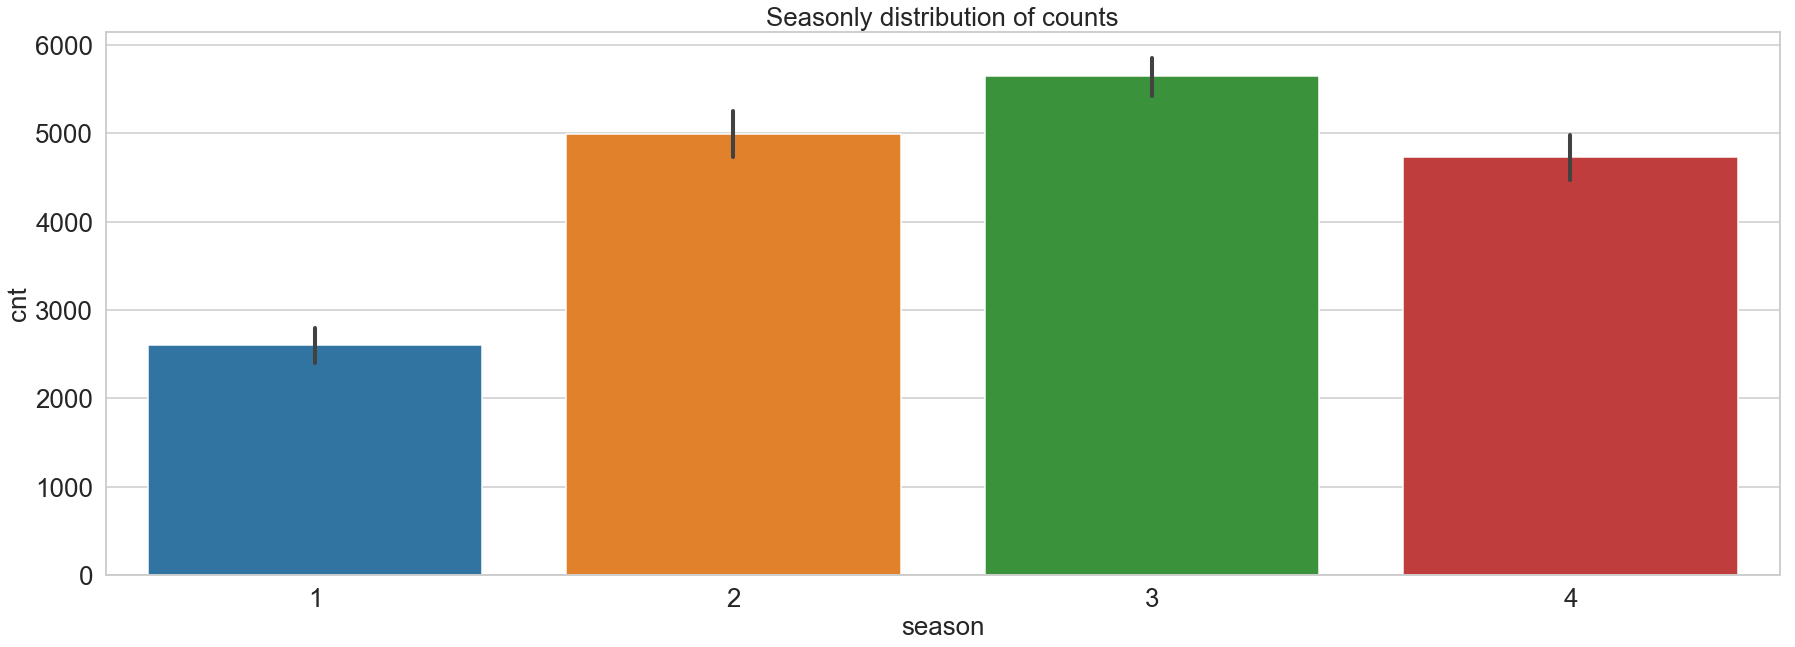

In [18]:
fig,ax = plt.subplots()
sn.barplot(data=train[['season',
                       'cnt']],
           x="season",y="cnt")
ax.set(title="Seasonly distribution of counts")

## 月份与骑车数量的关系

[Text(0.5, 1.0, 'Monthly distribution of counts')]

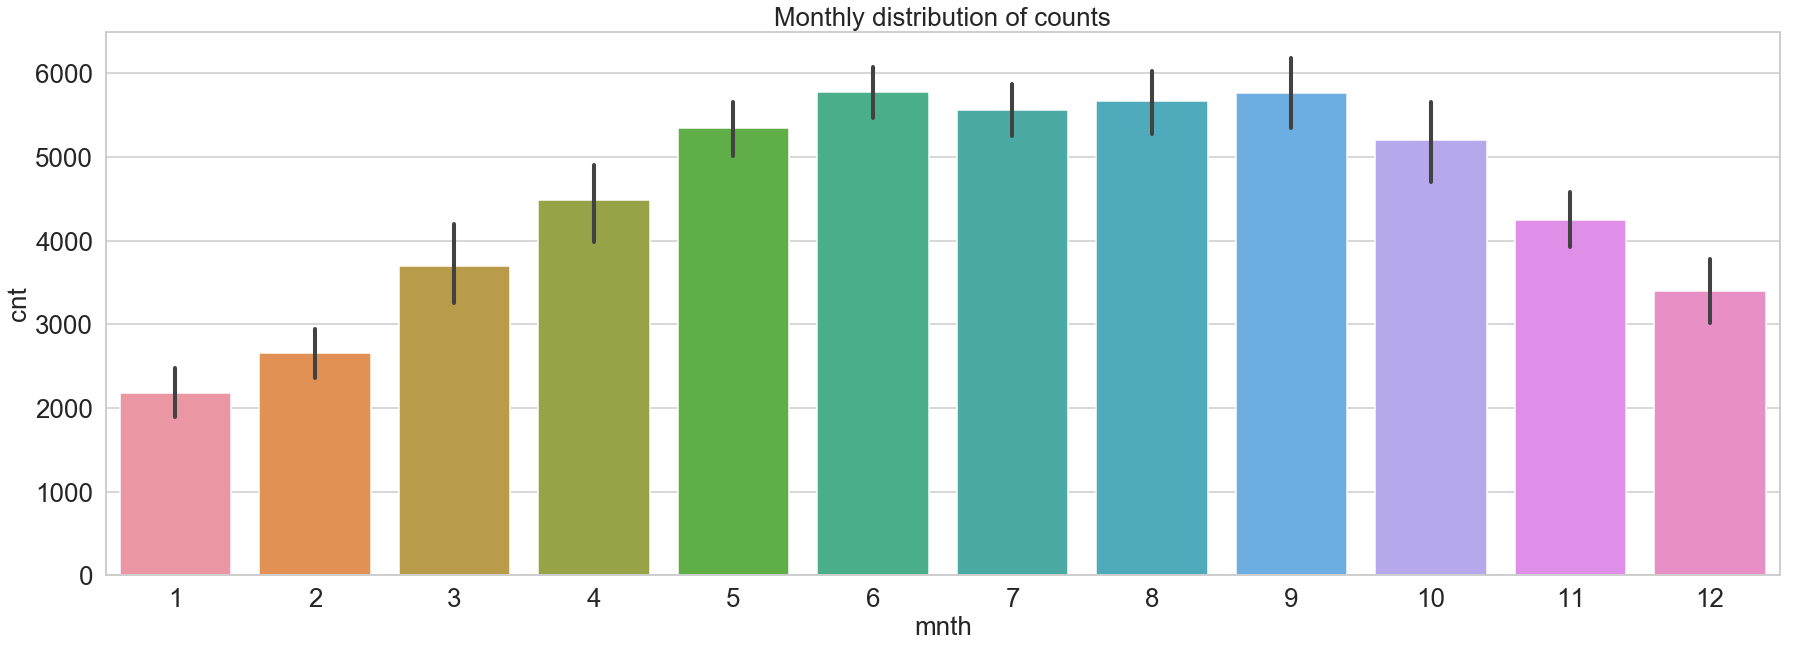

In [19]:
fig,ax = plt.subplots()
sn.barplot(data=train[['mnth',
                       'cnt']],
           x="mnth",y="cnt")
ax.set(title="Monthly distribution of counts")

## 天气和骑车数目的关系

[Text(0.5, 1.0, 'weathersit distribution of counts')]

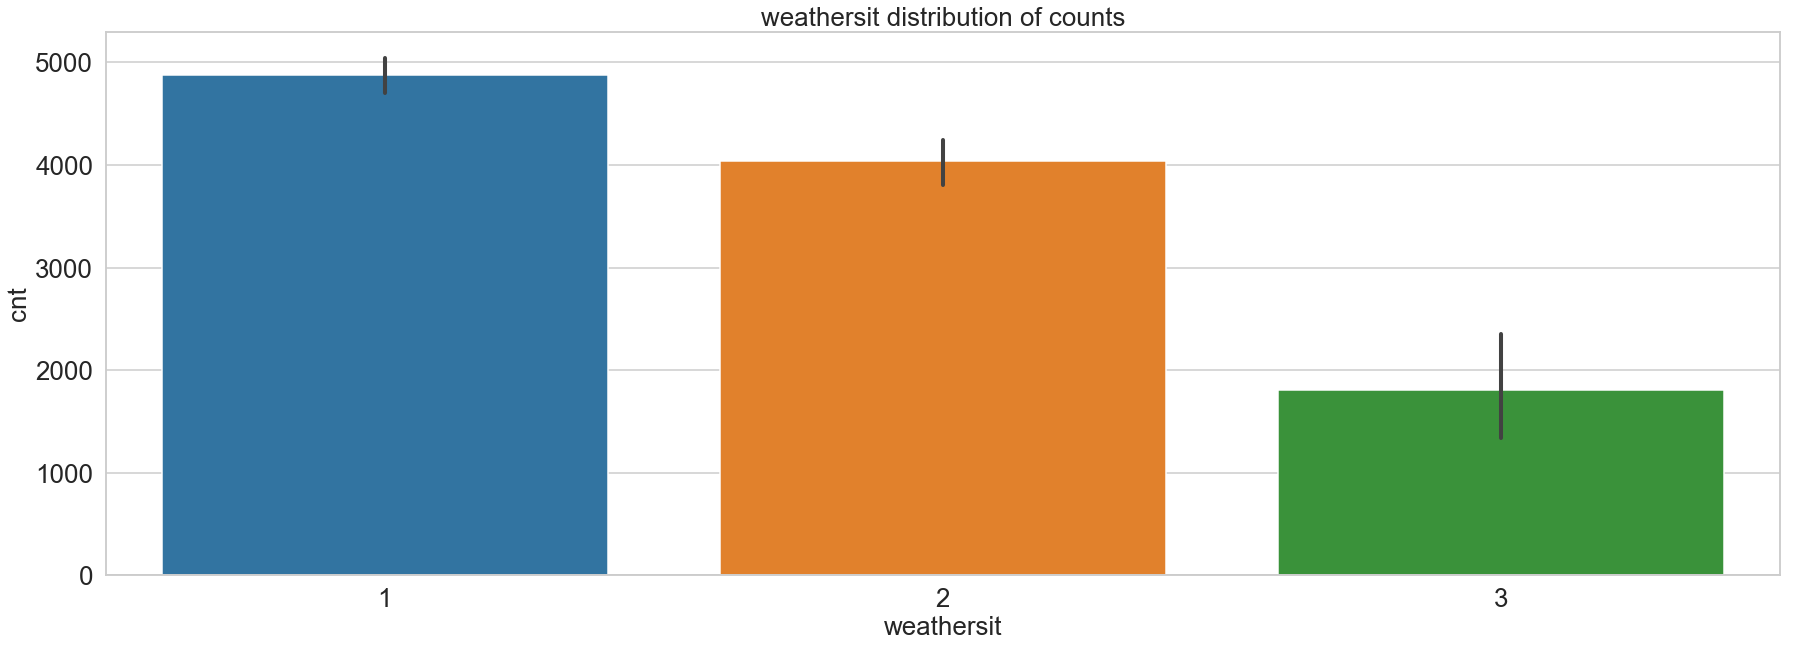

In [20]:
fig,ax = plt.subplots()
sn.barplot(data=train[['weathersit',
                       'cnt']],
           x="weathersit",y="cnt")
ax.set(title="weathersit distribution of counts")

## 工作日和节假日的分布

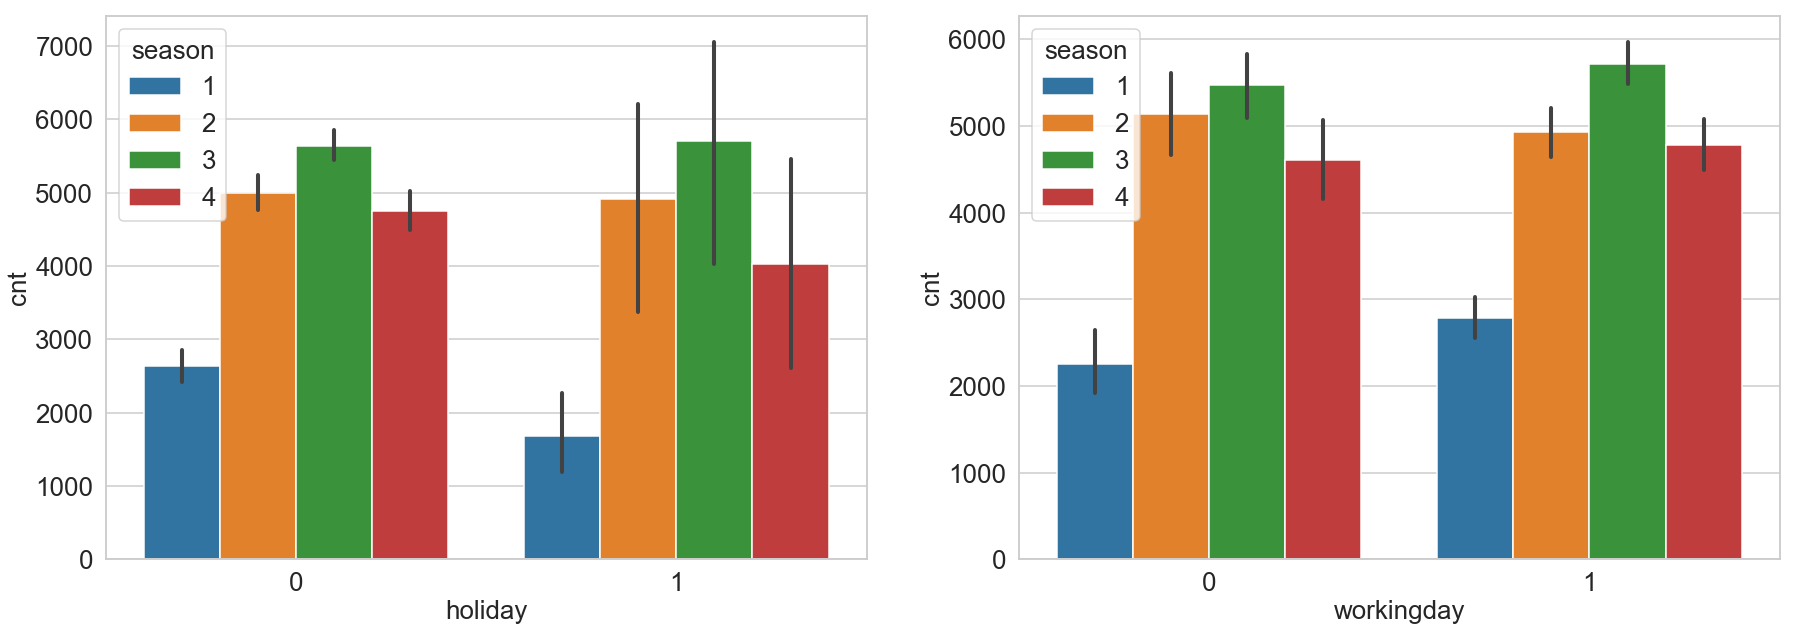

In [21]:
fig,(ax1,ax2) = plt.subplots(ncols=2)
sn.barplot(data=train,x='holiday',y='cnt',hue='season',ax=ax1)
sn.barplot(data=train,x='workingday',y='cnt',hue='season',ax=ax2)

## 相关性

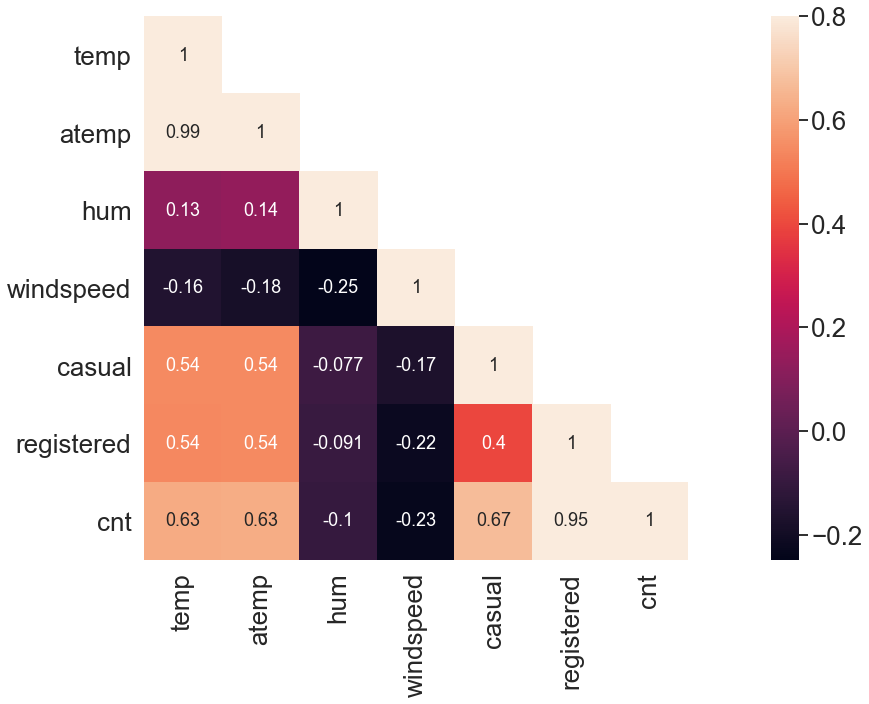

In [22]:
corrMatt = train[["temp","atemp",
                  "hum","windspeed",
                  "casual","registered",
                  "cnt"]].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
sn.heatmap(corrMatt, mask=mask,
           vmax=.8, square=True,annot=True)

## 特征工程

In [11]:
categorical_features = ['season','mnth','weathersit','weekday']
x_train_cat = train[categorical_features]
x_train_cat = pd.get_dummies(x_train_cat)
x_train_cat.head()

,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,weathersit_1,weathersit_2,weathersit_3,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,1,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,1,0,0,0,0
4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0


In [12]:
#数值型变量预处理
from sklearn.preprocessing import MinMaxScaler
mn_x = MinMaxScaler()
numerical_features = ['temp','atemp','hum','windspeed']
temp = mn_x.fit_transform(train[numerical_features])

x_train_num = pd.DataFrame(data=temp, columns=numerical_features, index =train.index)
x_train_num.head()

,temp,atemp,hum,windspeed
0,0.355170,0.373517,0.828620,0.284606
1,0.379232,0.360541,0.715771,0.466215
2,0.171000,0.144830,0.449638,0.465740
3,0.175530,0.174649,0.607131,0.284297
4,0.209120,0.197158,0.449313,0.339143


In [13]:
# Join categorical and numerical features
x_train = pd.concat([x_train_cat, x_train_num, train['holiday'],  train['workingday']], axis = 1, ignore_index=False)
x_train.head()

,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,weekday_3,weekday_4,weekday_5,weekday_6,temp,atemp,hum,windspeed,holiday,workingday
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0.355170,0.373517,0.828620,0.284606,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.379232,0.360541,0.715771,0.466215,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.171000,0.144830,0.449638,0.465740,0,1
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.175530,0.174649,0.607131,0.284297,0,1
4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0.209120,0.197158,0.449313,0.339143,0,1


In [14]:
FE_train = pd.concat([train['instant'], x_train,  train['yr'],train['cnt']], axis = 1)
FE_train.to_csv('FE_day.csv', index=False)
FE_train.head()

,instant,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,...,weekday_5,weekday_6,temp,atemp,hum,windspeed,holiday,workingday,yr,cnt
0,1,1,0,0,0,1,0,0,0,0,...,0,1,0.355170,0.373517,0.828620,0.284606,0,0,0,985
1,2,1,0,0,0,1,0,0,0,0,...,0,0,0.379232,0.360541,0.715771,0.466215,0,0,0,801
2,3,1,0,0,0,1,0,0,0,0,...,0,0,0.171000,0.144830,0.449638,0.465740,0,1,0,1349
3,4,1,0,0,0,1,0,0,0,0,...,0,0,0.175530,0.174649,0.607131,0.284297,0,1,0,1562
4,5,1,0,0,0,1,0,0,0,0,...,0,0,0.209120,0.197158,0.449313,0.339143,0,1,0,1600


In [15]:
FE_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 35 columns):
instant         731 non-null int64
season_1        731 non-null uint8
season_2        731 non-null uint8
season_3        731 non-null uint8
season_4        731 non-null uint8
mnth_1          731 non-null uint8
mnth_2          731 non-null uint8
mnth_3          731 non-null uint8
mnth_4          731 non-null uint8
mnth_5          731 non-null uint8
mnth_6          731 non-null uint8
mnth_7          731 non-null uint8
mnth_8          731 non-null uint8
mnth_9          731 non-null uint8
mnth_10         731 non-null uint8
mnth_11         731 non-null uint8
mnth_12         731 non-null uint8
weathersit_1    731 non-null uint8
weathersit_2    731 non-null uint8
weathersit_3    731 non-null uint8
weekday_0       731 non-null uint8
weekday_1       731 non-null uint8
weekday_2       731 non-null uint8
weekday_3       731 non-null uint8
weekday_4       731 non-null uint8
weekday_5       731 

## 回归

## 数据准备

In [54]:
# 从原始数据中分离输入特征x和输出y
y = train['cnt'].values
# 去掉y和不相关的特征
X = train.drop(['cnt','registered','casual','dteday','date','dayofyear'], axis = 1)
columns = X.columns
X.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446
1,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539
2,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309
3,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296
4,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900


In [55]:
X.shape

(731, 12)

In [56]:
from sklearn.model_selection import train_test_split

# 随机采样20%的数据构建测试样本，其余作为训练样本
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=33, test_size=0.2)
X_train.shape

(584, 12)

## 数据标准化

In [57]:
from sklearn.preprocessing import StandardScaler

# 分别初始化对特征和目标值的标准化器
ss_X = StandardScaler()
ss_y = StandardScaler()

# 分别对训练和测试数据的特征以及目标值进行标准化处理
X_train = ss_X.fit_transform(X_train)
X_test = ss_X.transform(X_test)

#对y做标准化不是必须
#对y标准化的好处是不同问题的w差异不太大，同时正则参数的范围也有限
y_train = ss_y.fit_transform(y_train.reshape(-1, 1))
y_test = ss_y.transform(y_test.reshape(-1, 1))

/Users/LordLuking/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/LordLuking/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/Users/LordLuking/anaconda/envs/tensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  if __name__ == '__main__':
/Users/LordLuking/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/utils/validation.py:590: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Us

In [58]:
x_train.head()

,season_1,season_2,season_3,season_4,mnth_1,mnth_2,mnth_3,mnth_4,mnth_5,mnth_6,...,weekday_3,weekday_4,weekday_5,weekday_6,temp,atemp,hum,windspeed,holiday,workingday
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0.355170,0.373517,0.828620,0.284606,0,0
1,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.379232,0.360541,0.715771,0.466215,0,0
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.171000,0.144830,0.449638,0.465740,0,1
3,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0.175530,0.174649,0.607131,0.284297,0,1
4,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0.209120,0.197158,0.449313,0.339143,0,1


## 最小二乘线性回归模型

In [59]:
# 线性回归
#class sklearn.linear_model.LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=1)
from sklearn.linear_model import LinearRegression

# 使用默认配置初始化
lr = LinearRegression()

# 训练模型参数
lr.fit(X_train, y_train)

# 预测
y_test_pred_lr = lr.predict(X_test)
y_train_pred_lr = lr.predict(X_train)


# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef":list((lr.coef_.T))})
fs.sort_values(by=['coef'],ascending=False)

,columns,coef
2,yr,[1.4286815977773555]
3,mnth,[0.42743454935728775]
1,season,[0.3041985312871963]
9,atemp,[0.2487796232674787]
8,temp,[0.23569164083821006]
5,weekday,[0.06956207484487609]
6,workingday,[0.04514524994041292]
4,holiday,[-0.02917687120063021]
10,hum,[-0.053534191214862956]
11,windspeed,[-0.08916019538030694]


## 模型估计

In [76]:
# 使用RMSE评价模型在测试集和训练集上的性能，并输出评估结果
#测试集
print('The RMSE of LinearRegression on test is', np.sqrt(mean_squared_error(y_test, y_test_pred_lr)))
#训练集
print('The RMSE of LinearRegression on train is', np.sqrt(mean_squared_error(y_train, y_train_pred_lr)))

The RMSE of LinearRegression on test is 0.4274216705289743
The RMSE of LinearRegression on train is 0.4533801608416963


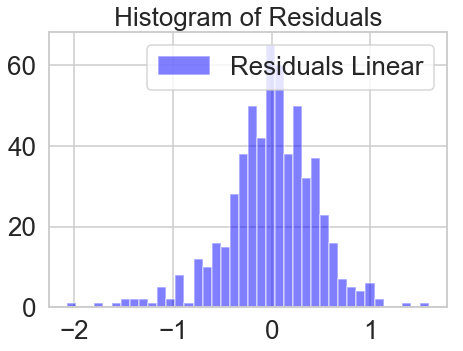

In [65]:
#在训练集上观察预测残差的分布，看是否符合模型假设：噪声为0均值的高斯噪声
f, ax = plt.subplots(figsize=(7, 5)) 
f.tight_layout() 
ax.hist(y_train - y_train_pred_lr,bins=40, label='Residuals Linear', color='b', alpha=.5); 
ax.set_title("Histogram of Residuals") 
ax.legend(loc='best');

残差分布和高斯分布比较匹配，但还是右skew

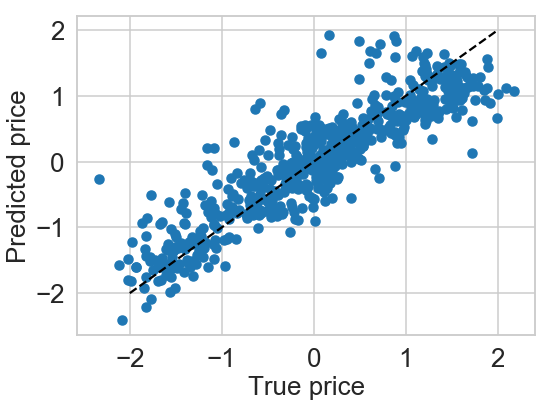

In [70]:
#还可以观察预测值与真值的散点图
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred_lr)
plt.plot([-2, 2], [-2, 2], '--k')   
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.tight_layout()

y值大的部分不太好

## 岭回归

In [72]:
from sklearn.linear_model import  RidgeCV

#设置超参数（正则参数）范围
alphas = [ 0.01, 0.1, 1, 10,100]

#生成一个RidgeCV实例
ridge = RidgeCV(alphas=alphas,cv=5)  

#模型训练
ridge.fit(X_train, y_train)    

#预测
y_test_pred_ridge = ridge.predict(X_test)
y_train_pred_ridge = ridge.predict(X_train)

In [74]:
# Hyperparameter
alpha = ridge.alpha_
print('超参数alpha:',alpha)

超参数alpha: 10.0


In [75]:
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T))})
fs.sort_values(by=['coef_lr'],ascending=False)

,columns,coef_lr,coef_ridge
2,yr,[1.4286815977773555],[0.3926766475806896]
3,mnth,[0.42743454935728775],[-0.1385618089858953]
1,season,[0.3041985312871963],[0.2783083943348016]
9,atemp,[0.2487796232674787],[0.25130444651090483]
8,temp,[0.23569164083821006],[0.2335077278205062]
5,weekday,[0.06956207484487609],[0.06776464467894142]
6,workingday,[0.04514524994041292],[0.0436290459438142]
4,holiday,[-0.02917687120063021],[-0.029868791152434408]
10,hum,[-0.053534191214862956],[-0.06294137965529727]
11,windspeed,[-0.08916019538030694],[-0.09309314839480372]


## 评估

In [77]:
# 评估，使用RMSE评价模型在测试集和训练集上的性能
print('The RMSE of RidgeCV on test is', np.sqrt(mean_squared_error(y_test, y_test_pred_ridge)))
print('The RMSE of RidgeCV on train is', np.sqrt(mean_squared_error(y_train, y_train_pred_ridge)))

The RMSE of RidgeCV on test is 0.4254906737014429
The RMSE of RidgeCV on train is 0.45623596489460055


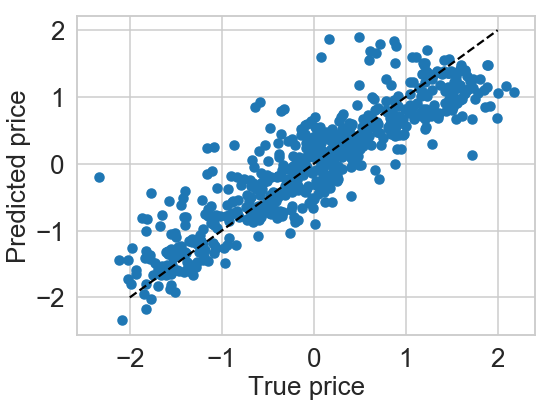

In [78]:
# 散点图
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred_ridge)
plt.plot([-2, 2], [-2, 2], '--k')   
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.tight_layout()

## LASSO模型

In [82]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(alphas=alphas,cv=5)  

#训练（内含CV）
lasso.fit(X_train, y_train)  

#测试
y_test_pred_lasso = lasso.predict(X_test)
y_train_pred_lasso = lasso.predict(X_train)

#Hyperparameter
print('超参数alpha为：',lasso.alpha_)



超参数alpha为： 0.01


/Users/LordLuking/anaconda/envs/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1108: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [85]:
# 看看各特征的权重系数，系数的绝对值大小可视为该特征的重要性
fs = pd.DataFrame({"columns":list(columns), "coef_lr":list((lr.coef_.T)), "coef_ridge":list((ridge.coef_.T)), "coef_lasso":list((lasso.coef_.T))})
fs.sort_values(by=['coef_lr'],ascending=False)

,columns,coef_lr,coef_ridge,coef_lasso
2,yr,[1.4286815977773555],[0.3926766475806896],0.522253
3,mnth,[0.42743454935728775],[-0.1385618089858953],-0.021166
1,season,[0.3041985312871963],[0.2783083943348016],0.238309
9,atemp,[0.2487796232674787],[0.25130444651090483],0.269177
8,temp,[0.23569164083821006],[0.2335077278205062],0.214679
5,weekday,[0.06956207484487609],[0.06776464467894142],0.058887
6,workingday,[0.04514524994041292],[0.0436290459438142],0.037327
4,holiday,[-0.02917687120063021],[-0.029868791152434408],-0.025127
10,hum,[-0.053534191214862956],[-0.06294137965529727],-0.051614
11,windspeed,[-0.08916019538030694],[-0.09309314839480372],-0.082285


## 评估

In [84]:
# 评估，使用RMSE评价模型在测试集和训练集上的性能
print('The RMSE of LassoCV on test is', np.sqrt(mean_squared_error(y_test, y_test_pred_lasso)))
print('The RMSE of LassoCV on train is', np.sqrt(mean_squared_error(y_train, y_train_pred_lasso)))

The RMSE of LassoCV on test is 0.42708641693568244
The RMSE of LassoCV on train is 0.4573768980840869


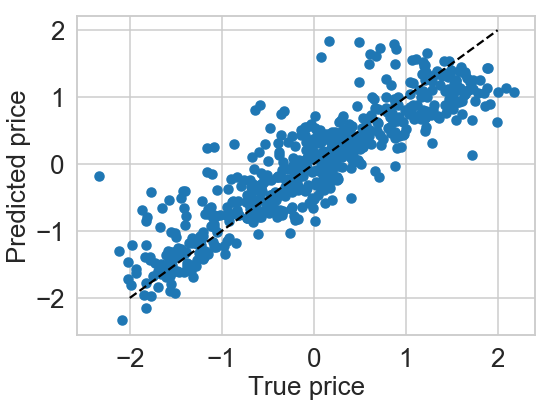

In [83]:
# 散点图
plt.figure(figsize=(8, 6))
plt.scatter(y_train, y_train_pred_lasso)
plt.plot([-2, 2], [-2, 2], '--k')   
plt.axis('tight')
plt.xlabel('True price')
plt.ylabel('Predicted price')
plt.tight_layout()

## 总结
三种模型区别不大。相对来说，岭回归模型在训练集中表现略好一点点。